# Processing for Manifest ⭐

## Imports

In [1]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import cv2
import numpy as np
from PIL import Image


## AudioSet Ontology

### Loading ontology and making Heirarchy

In [2]:

ontology_file_path = '/tmp/bld56_dataset_v1/audioset/annotations/ontology.json'

# Load the ontology data
with open(ontology_file_path) as f:
    ontology_data = json.load(f)

# Create a dictionary to store the hierarchy
hierarchy = {}
for item in ontology_data:
    hierarchy[item['id']] = {
        'name': item['name'],
        'children': item.get('child_ids', [])
    }

# Function to recursively print the hierarchy with tree-like structure
def print_hierarchy(node_id, prefix='', is_last=True):
    node = hierarchy[node_id]
    connector = '└── ' if is_last else '├── '
    print(prefix + connector + f"{node_id}: {node['name']}")
    prefix += '    ' if is_last else '│   '
    for i, child_id in enumerate(node['children']):
        is_last_child = (i == len(node['children']) - 1)
        print_hierarchy(child_id, prefix, is_last_child)

# Find the root nodes (nodes without parents)
root_nodes = set(hierarchy.keys())
for item in ontology_data:
    for child_id in item.get('child_ids', []):
        if child_id in root_nodes:
            root_nodes.remove(child_id)

# Print the hierarchy starting from each root node
for root_id in sorted(root_nodes):
    print_hierarchy(root_id)


└── /m/04rlf: Music
    ├── /m/04szw: Musical instrument
    │   ├── /m/0fx80y: Plucked string instrument
    │   │   ├── /m/0342h: Guitar
    │   │   │   ├── /m/02sgy: Electric guitar
    │   │   │   ├── /m/018vs: Bass guitar
    │   │   │   ├── /m/042v_gx: Acoustic guitar
    │   │   │   ├── /m/06w87: Steel guitar, slide guitar
    │   │   │   ├── /m/01glhc: Tapping (guitar technique)
    │   │   │   └── /m/07s0s5r: Strum
    │   │   ├── /m/018j2: Banjo
    │   │   ├── /m/0jtg0: Sitar
    │   │   ├── /m/04rzd: Mandolin
    │   │   ├── /m/01bns_: Zither
    │   │   └── /m/07xzm: Ukulele
    │   ├── /m/05148p4: Keyboard (musical)
    │   │   ├── /m/05r5c: Piano
    │   │   │   └── /m/01s0ps: Electric piano
    │   │   │       ├── /m/025cbm: Clavinet
    │   │   │       └── /m/0bxl5: Rhodes piano
    │   │   ├── /m/013y1f: Organ
    │   │   │   ├── /m/03xq_f: Electronic organ
    │   │   │   └── /m/03gvt: Hammond organ
    │   │   ├── /m/0l14qv: Synthesizer
    │   │   │   ├── /m/01v1d8

### Function for getting all children, useful for list of labels to be avoided(never consider videos) and for find all child nodes function.

In [3]:
def get_all_children(node_id):
    node = hierarchy[node_id]
    nodes = [(node_id, node['name'])]
    for child_id in node['children']:
        nodes.extend(get_all_children(child_id))
    return nodes

ids = ["/m/0l14jd", "/m/0kpv1t", "/m/074ft", "/m/09x0r", "/m/02rtxlg","/m/015lz1", "/t/dd00089", "/m/09l8g", "/m/09hlz4"] #"/m/09l8g", "/m/09hlz4" -> Human Voice, Respiratory sounds
ids_to_be_avoided = []
for id in ids:
    # print(f"###################################Children of {id}:")
    for child_id, child_name in get_all_children(id):
        # print(f"  {child_id}: {child_name}")ids_to_be_avoided
        ids_to_be_avoided.append(child_id)


In [4]:
ids = ["/m/04rlf", "/m/096m7z", "/t/dd00093" ] # Music, Noise, Acoustic environment
mids_to_avoid = [ '/m/0c1dj', '/m/093_4n', '/t/dd00077', '/m/04rlf', '/t/dd00092','/m/096m7z','/t/dd00098','/t/dd00122','/m/059j3w','/t/dd00099'] # ['Sound Effect', 'Background Noise', 'Mechanisms', 'Music','Noise', 'Source-ambiguous sounds', 'Other sourceless','Natural Sounds','Generic Impact Sounds' ]
for id in ids:
    # print(f"###################################Children of {id}:")
    for child_id, child_name in get_all_children(id):
        # print(f"  {child_id}: {child_name}")mids_to_avoid
        mids_to_avoid.append(child_id)



### find_child_most_nodes given labels, not useful currently. Ref:[notion](https://www.notion.so/whissle/Notes-689a8cbc99b142ce84de0ffab2ed5800?pvs=4#8221c59473e44f728a573c438e5391b0)

In [5]:

def find_child_most_nodes(labels):
    child_most_labels = set()
    
    def has_children_in_labels(node_id, labels):
        if node_id in hierarchy.keys():
            for child_id in hierarchy[node_id]['children']:
                if child_id in labels or has_children_in_labels(child_id, labels):
                    return True
            return False
        else:
            return node_id in labels
    
    for label in labels:
        if not has_children_in_labels(label, labels):
            child_most_labels.add(label)
    
    return list(child_most_labels)

# Example usage
labels = ['/t/dd00123', '/m/07bm98', '/m/04zc0', '/t/dd00122']
child_most_nodes = find_child_most_nodes(labels)
print("Child Most Nodes:")
print(child_most_nodes)


Child Most Nodes:
['/t/dd00122', '/m/04zc0']


## SPLIT TYPE

In [2]:
split_type = 'train' # train, eval
file_type = 'normal' # normal, strong
def get_mid_to_label():
    if file_type == 'strong':
        mid_to_label_file_path = f'/tmp/bld56_dataset_v1/audioset/annotations/mid_to_display_name.tsv'
        mid_to_label = pd.read_csv(mid_to_label_file_path, sep='\t', names=['mid', 'label'])
    elif file_type == 'normal':
        mid_to_label_file_path = f'/tmp/bld56_dataset_v1/audioset/annotations/class_labels_indices.csv'
        mid_to_label = pd.read_csv(mid_to_label_file_path, sep=',', names=['index', 'mid', 'label'])
    return mid_to_label

## Code to Filter out non speech video segement from the actual audioset strong annotations

In [7]:
# Function to extract YouTube ID and start time
def extract_ytid_and_start(segment_id):
    ytid, startimems = segment_id.rsplit('_', 1)
    start_seconds = int(startimems) / 1000.0
    return ytid, start_seconds

mid_to_label = get_mid_to_label()

def get_csv_of_strong_as(ann_tsv_file):
    df = pd.read_csv(ann_tsv_file, sep='\t')

    # Apply the function to extract YTID and start_seconds
    df['YTID'], df['start_seconds'] = zip(*df['segment_id'].map(extract_ytid_and_start))

    # Calculate end_seconds from start_seconds
    df['end_seconds'] = df['start_seconds'] + 10.0

    # Group by YTID, start_seconds, and end_seconds and aggregate labels
    # get only child most labels
    # df['label'] = df['label'].apply(lambda x: find_child_most_nodes(x.split(',')))
    # df['label'] = df['label'].apply(lambda x: ','.join(x))
    # Group by YTID, start_seconds, and end_seconds and aggregate labels
    result = df.groupby(['YTID', 'start_seconds', 'end_seconds'])['label'].apply(lambda x: ',"' + ','.join(x) + '"').reset_index()

    for label in ids_to_be_avoided:
        # if label not in result['label'] coloumn then only consider that row
        result = result[~result['label'].str.contains(label)]

    # Rename columns to match the required output format
    result.rename(columns={
        'YTID': 'YTID',
        'start_seconds': 'start_seconds',
        'end_seconds': 'end_seconds',
        'label': 'positive_labels'
    }, inplace=True)
    print(f"Num Rows: {len(result)}")
    # Save to CSV file
    # result.to_csv(f'/tmp/bld56_dataset_v1/audioset/annotations/audioset_{split_type}_strong.csv', index=False) #!! only save once

def get_dfs_for_as(filepath):
    dfs = {}
    data = []
    
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('#'):
                continue  # Skip comment lines
            parts = line.split(',')
            parts = parts[:3] + [','.join(parts[3:])]
            data.append(parts)
    
    # Create DataFrame from parsed data
    df = pd.DataFrame(data, columns=['YTID', 'start_seconds', 'end_seconds', 'positive_labels'])
    
    # Ensure YTID contains only alphanumeric characters
    # df['YTID'] = df['YTID'].str.replace(r'\W', '', regex=True)
    # label -> "/m/01g50p,/m/0284vy3,/m/06d_3,/m/07jdr,/m/07rwm0c"
    # strip the " , " from the positive_labels
    df['positive_labels'] = df['positive_labels'].str.strip().str.strip('"')

    # remove those rows where any label in ids_to_be_avoided is present in positive_labels
    for label in ids_to_be_avoided:
        df = df[~df['positive_labels'].str.contains(label)]
    
    # Split the positive_labels column into multiple rows
    df = df.assign(positive_labels=df['positive_labels'].str.split(',')).explode('positive_labels')
    
    # Rename columns to match the desired format
    df = df.rename(columns={
        'start_seconds': 'start_time_seconds',
        'end_seconds': 'end_time_seconds',
        'positive_labels': 'label'
    })
    
    
    # Keep the necessary columns and reorder them
    df = df[['start_time_seconds', 'end_time_seconds', 'label', 'YTID', 'start_time_seconds', 'end_time_seconds']]
    
    # Rename columns to match the final format
    df.columns = ['start_time_seconds', 'end_time_seconds', 'label', 'YTID', 'start_seconds', 'end_seconds']
    
    # convert start_seconds and end_seconds, start_time_seconds and end_time_seconds to float
    df['start_seconds'] = df['start_seconds'].astype(float)
    df['end_seconds'] = df['end_seconds'].astype(float)
    df['end_time_seconds'] = df['end_time_seconds'].astype(float)
    df['start_time_seconds'] = df['start_time_seconds'].astype(float)
    
    
    # remove rows with mids_to_avoid
    df = df[~df['label'].isin(mids_to_avoid)]
    
    dfs[split_type] = df
    return dfs
    
    
if file_type == 'strong':
    get_csv_of_strong_as(f'/tmp/bld56_dataset_v1/audioset/annotations/audioset_{split_type}_strong.tsv')
elif file_type == 'normal':
    if split_type == 'train':
        dfs = get_dfs_for_as(f'/tmp/bld56_dataset_v1/audioset/annotations/unbalanced_train_segments.csv')
    elif split_type == 'eval':
        dfs = get_dfs_for_as(f'/tmp/bld56_dataset_v1/audioset/annotations/eval_segments.csv')
else: 
    raise NotImplementedError(f"File type {file_type} not implemented")


## Code to check num downloaded from files that we have

In [8]:

def get_files_downloaded(split_type, u_l,l_l,base_dir):
    dir = base_dir + split_type+'/videos/'
    files = os.listdir(dir)
    ann_csv_file = base_dir + f'annotations/audioset_{split_type}_strong.csv'
    df = pd.read_csv(ann_csv_file)
    df['YTID'] = df['YTID'].apply(lambda x: ''.join(e for e in x if e.isalnum()))
    files = [f.split('.')[0] for f in files]
    if split_type=='eval':        
        df = df[df['YTID'].isin(files)]
        # return list of files downloaded
        return df['YTID'].tolist()
    else:
        # select only rows from lower and upper limit
        df = df[l_l:u_l]
        df = df[df['YTID'].isin(files)]
        # return list of files downloaded
        return df['YTID'].tolist()

if __name__ == '__main__':
    base_dir = '/tmp/bld56_dataset_v1/audioset/'
    for l_l in range(0,60000,10000):
        u_l = l_l + 10000
        print(f"{l_l} to {u_l} -> {len(get_files_downloaded('train', u_l, l_l, base_dir))}")
    print(f"Eval\n 0 to 7215-> {len(get_files_downloaded('eval', 0, 7215, base_dir))}")

0 to 10000 -> 5876
10000 to 20000 -> 5869
20000 to 30000 -> 5685
30000 to 40000 -> 4703
40000 to 50000 -> 0


50000 to 60000 -> 0
Eval
 0 to 7215-> 4003


👆👆 Download more videos again, and focus on redownloading videos if their status acc as_info is not good 🚀

## Analysis and Filtering of the data for selecting the noise classes

### Functions for filtering of Data

In [9]:
def extract_ytid_and_start(segment_id):
    ytid, startimems = segment_id.rsplit('_', 1)
    start_seconds = int(startimems) / 1000.0
    return ytid, start_seconds


def get_filtered_df(ann_file_real, ann_file_speech_rem):
    dfs_filtered = {}
    df_real = pd.read_csv(base_dir + ann_file_real, sep='\t')
    df_speech_rem = pd.read_csv(base_dir + ann_file_speech_rem)
    df_real['YTID'], df_real['start_seconds'] = zip(*df_real['segment_id'].map(extract_ytid_and_start))
    df_real['end_seconds'] = df_real['start_seconds'] + 10.0
    # select YTID's that are present in df_speech_rem only
    print(f"Num IDs in {split_type} -> {len(df_real['YTID'].unique())}")
    df_real = df_real[df_real['YTID'].isin(df_speech_rem['YTID'])]
    print(f"{split_type} -> {len(df_real['YTID'].unique())}")
    dfs_filtered[split_type] = df_real
    return dfs_filtered

def get_samples_greater_than_given_len(df, len):
    return df[df['end_time_seconds'] - df['start_time_seconds'] > len]

def filter_samples_with_given_labels(df, labels):
    for label in labels:
        df = df[~df['label'].str.contains(label)]
    return df

def get_samples_with_mean_label_time_greater_than_given_len(df, length):
    # Check if necessary columns exist
    if 'label' not in df.columns or 'start_time_seconds' not in df.columns or 'end_time_seconds' not in df.columns:
        raise ValueError("DataFrame must contain 'label', 'start_time_seconds', and 'end_time_seconds' columns")

    # Calculate mean time for each label
    df['duration'] = df['end_time_seconds'] - df['start_time_seconds']
    label_vs_mean_time = df.groupby('label')['duration'].mean()

    # Filter labels with mean time greater than the specified length
    len_filtered_labels = label_vs_mean_time[label_vs_mean_time > length].index

    # Select only those rows that have the filtered labels
    df_filtered = df[df['label'].isin(len_filtered_labels)]

    return df_filtered

def merge_samples_with_same_ytid_and_same_label_with_gap(df, gap):
    # Check if necessary columns exist
    if 'label' not in df.columns or 'start_time_seconds' not in df.columns or 'end_time_seconds' not in df.columns or 'YTID' not in df.columns:
        raise ValueError("DataFrame must contain 'label', 'start_time_seconds', 'end_time_seconds', and 'YTID' columns")

    # Sort the DataFrame by YTID, label, and start_time_seconds
    df = df.sort_values(['YTID', 'label', 'start_time_seconds'])

    # Calculate the time gap between the end time of the current row and the start time of the next row
    df['prev_end_time'] = df.groupby(['YTID', 'label'])['end_time_seconds'].shift()
    df['time_gap'] = df['start_time_seconds'] - df['prev_end_time']

    # If the time gap is less than or equal to the specified gap, merge the rows
    df['merge'] = (df['time_gap'] <= gap).astype(int)
    df['merge'] = df.groupby(['YTID', 'label'])['merge'].cumsum()
    df['start_time_seconds'] = df.groupby(['YTID', 'label', 'merge'])['start_time_seconds'].transform('min')
    df['end_time_seconds'] = df.groupby(['YTID', 'label', 'merge'])['end_time_seconds'].transform('max')

    # Drop unnecessary columns and duplicates
    df = df.drop(columns=['prev_end_time', 'time_gap', 'merge']).drop_duplicates()

    return df

def rem_samples_from_mids_to_avoid (df, mids_to_avoid):
    for mid in mids_to_avoid:
        df = df[~df['label'].str.contains(mid)]
    return df

def get_num_samples_for_given_labels(df, labels):
    # label vs num_samples to be returned
    label_vs_num_samples = {}
    for label in labels:
        label_vs_num_samples[label] = len(df[df['label'].str.contains(label)])
    return label_vs_num_samples


### Functions for plotting

In [10]:
def plot_num_videos_vs_num_labels(df):
    # Filter out rows with labels to avoid
    df_filtered = df[~df['label'].isin(mids_to_avoid)]
    
    df = df_filtered
    
    # Count the number of labels per video (YTID)
    video_label_counts = df.groupby('YTID').size()
    print(f"Num of videos -> {len(video_label_counts)}")
    # Count the number of videos with each number of labels
    label_count_distribution = video_label_counts.value_counts().sort_index()
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(label_count_distribution.index, label_count_distribution.values)
    plt.xlabel('Number of Labels')
    plt.ylabel('Number of Videos')
    plt.title('Number of Videos vs. Number of Labels')
    plt.xticks(label_count_distribution.index)
    plt.grid(axis='y')
    plt.show()

def plot_label_vs_count(label_to_count, mid_to_label,min_num_samples ):
    """
    Plots a bar chart of labels vs. their counts.
    
    Args:
        label_to_count (dict): Dictionary mapping labels to their counts.
        mid_to_label (pd.DataFrame): DataFrame containing label mapping.
        min_num_samples (int): Minimum number of samples for a label to be included in the plot.
    Returns:
        None
    """
    plt.figure(figsize=(20, 10))
    label_to_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_count.items()}
    # keep only labels with samples greater than min_nu_samples and keep key with key_idx
    label_to_count = {k: v for k, v in label_to_count.items() if v > min_num_samples}
    # plot
    plt.bar(label_to_count.keys(), label_to_count.values())
    for i, v in enumerate(label_to_count.values()):
        plt.text(i, v, str(v), ha='center', fontsize='small')
    plt.title('Label vs Count')
    plt.xticks(rotation=90)
    # in plot legend add text saying num keys
    plt.legend([f'Num keys -> {len(label_to_count)}'])
    plt.show()

def plot_percentile_label_vs_count(label_to_count, mid_to_label, bin_size=10, value_range=(0, 500)):
    """
    Plots a histogram of counts vs. number of labels.
    
    Args:
        label_to_count (dict): Dictionary mapping labels to their counts.
        mid_to_label (pd.DataFrame): DataFrame containing label mapping.
        bin_size (int): Size of the bins for the histogram.
        value_range (tuple): Range of values for the x-axis.
    Returns:
        None
    """
    # Convert the label_to_count to use the actual label names
    label_to_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_count.items()}
    
    # Create a list of counts
    counts = list(label_to_count.values())
    
    # Define the bins
    bins = range(value_range[0], value_range[1] + bin_size, bin_size)
    
    # Plot the histogram
    plt.figure(figsize=(20, 10))
    plt.hist(counts, bins=bins, edgecolor='black', align='left')
    
    # Calculate the number of labels in each bin
    bin_counts, bin_edges = np.histogram(counts, bins=bins)
    
    # Add text labels on top of the bars
    for i in range(len(bin_counts)):
        plt.text(bin_edges[i] + bin_size/2, bin_counts[i], str(bin_counts[i]), ha='center')
    
    plt.title('Count vs Number of Labels')
    plt.xlabel('Count')
    plt.ylabel('Number of Labels')
    plt.xticks(bin_edges, rotation=90)
    plt.legend([f'Num keys -> {len(label_to_count)}'])
    plt.show()

# plot binned time on x with 1sec and num samples in that bin on y
def plot_binned_time_vs_num_samples(df, bin_size=1,add_coloumn_of_probs=True, consider_num_samples_per_bin=True):
    base_dir = '/tmp/bld56_dataset_v1/audioset/' + split_type+'/videos/'
    base_dir_feats = '/tmp/bld56_dataset_v1/audioset/' + split_type+'/feats_ViT-L-14_5fps/' 
    as_info_file = '/tmp/bld56_dataset_v1/audioset/' + split_type + '/info.json'
    bins = range(0, int(df['duration'].max()) + bin_size, bin_size)
    df['binned_duration'] = pd.cut(df['duration'], bins)
    num_samples_per_bin = df['binned_duration'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    num_samples_per_bin.plot(kind='bar')
    plt.title('Duration vs Number of Samples')
    plt.xlabel('Duration Bins')
    plt.ylabel('Number of Samples')
    # add count on top of each bar
    for i, v in enumerate(num_samples_per_bin):
        plt.text(i, v, str(v), ha='center', fontsize='small')
    plt.tight_layout()
    plt.show()
    if add_coloumn_of_probs:
        if consider_num_samples_per_bin:
            # add prbs_with_duration coloumn to df with inverse probality of duration with respect to num_samples_per_bin
            df['prbs_with_duration'] = df['binned_duration'].apply(lambda x: len(df)/num_samples_per_bin[x])
        else:
            # keep 1 for all
            df['prbs_with_duration'] = 1
        videos_list = os.listdir(base_dir)
        feats_list = os.listdir(base_dir_feats)
        as_info = json.load(open(as_info_file))
        # /disk1/audioset/train/videos/lIae8amfSdg.mp4 -> keys in as_info, convert them to lIae8amfSdg
        as_info = {k.split('/')[-1].split('.')[0]: v for k, v in as_info.items()}
        
        df['is_present'] = df['YTID'].apply(lambda x: x + '.mp4' in videos_list and x + '.npy' in feats_list)
        df['is_present'] = df['is_present'] & df['YTID'].apply(lambda x: x in as_info.keys() and as_info[x]['has_video'] and as_info[x]['has_audio'])
        # remove rows where video is not present
        df = df[df['is_present']]
        # df['prbs_with_duration'] = df.apply(lambda x: x['prbs_with_duration'] if x['is_present'] else 1e-9, axis=1)
    return df


### Filtering

In [11]:
if file_type == 'strong':
    ann_files_real = f'audioset_{split_type}_strong.tsv'
    ann_files_speech_rem = f'audioset_{split_type}_strong.csv'
    base_dir = '/tmp/bld56_dataset_v1/audioset/annotations/'

    dfs = get_filtered_df(ann_files_real, ann_files_speech_rem)

In [12]:
print(f"Split Type -> {split_type}")
df = dfs[split_type]
df = get_samples_greater_than_given_len(df, 1)
if file_type == 'strong':
    df = merge_samples_with_same_ytid_and_same_label_with_gap(df, 0.5)
print(f"Num samples greater than 1 sec -> {len(df)}")
df = get_samples_with_mean_label_time_greater_than_given_len(df, 2)
print(f"Num samples with mean label time greater than 2 sec -> {len(df)}, Num labels -> {len(df['label'].unique())}")
print(f"Num of Unique YTID's -> {len(df['YTID'].unique())}")

Split Type -> train
Num samples greater than 1 sec -> 528069
Num samples with mean label time greater than 2 sec -> 528069, Num labels -> 300


/tmp/ipykernel_3455385/3218543985.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration'] = df['end_time_seconds'] - df['start_time_seconds']


Num of Unique YTID's -> 276414


Num of videos -> 276414


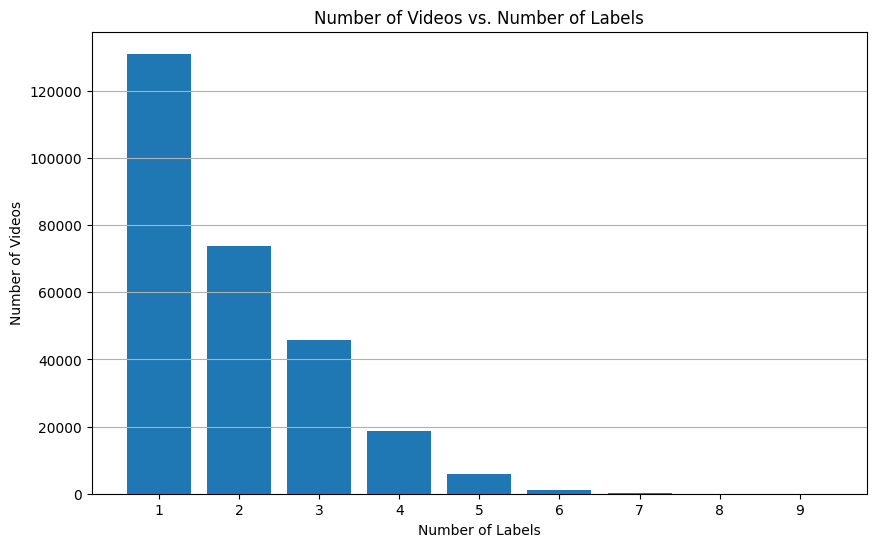

In [13]:
plot_num_videos_vs_num_labels(df)

## Processing anns for max label or single label only samples

In [14]:
def process_youtube_data_with_max(df, with_music=False, eval=False, labels_considered=[]):
    """
    Process YouTube data to find the label with the maximum duration for each YTID,
    and then count and print the labels in descending order of their counts.
    
    Args:
        df (pd.DataFrame): DataFrame containing YouTube segment data.
    
    Returns:
        ytid_to_label_max_duration (dict): mapping YTID to label with the maximum duration.
        label_to_count (dict): mapping label to its count.
    """
    dir = '/tmp/bld56_dataset_v1/audioset/' + split_type+'/videos/'
    # Convert DataFrame to dictionary records
    data = df.to_dict('records')
    # Initialize the dictionary to store the label with max duration for each YTID
    ytid_to_label = {}
    files_list = os.listdir(dir)
    # Iterate over each row in the data
    for row in data:
        ytid = row['YTID']
        label = row['label']
        duration = row['duration']

        # If the YTID is not in the dictionary, or if the current duration is greater than the stored one
        if (ytid not in ytid_to_label or duration > ytid_to_label[ytid]['duration'] )and not (with_music and (label in mids_to_avoid)):
            if eval and label not in labels_considered:
                continue
            ytid_to_label[ytid] = {'label': label, 'duration': duration, 'start_time': row['start_time_seconds'], 'end_time': row['end_time_seconds']}

    # Create a final dictionary with YTID to the label with the max duration
    ytid_to_label_max_duration = {ytid: value['label'] for ytid, value in ytid_to_label.items()}

    # Get label to count dictionary
    label_to_count = {}
    for ytid, label in ytid_to_label_max_duration.items():
        if label in label_to_count:
            label_to_count[label] += 1
        else:
            label_to_count[label] = 1

    # Sort the label to count dictionary by count in descending order
    label_to_count = dict(sorted(label_to_count.items(), key=lambda item: item[1], reverse=True))


    return ytid_to_label_max_duration, label_to_count, ytid_to_label

def process_youtube_data_filtered(df, with_music=False, eval=False, labels_considered=[]):
    """
    Process YouTube data to filter out YTIDs with only one label after avoiding certain label,
    and then count and print the labels in descending order of their counts.
    
    Args:
        df (pd.DataFrame): DataFrame containing YouTube segment data.
    
    Returns:
        ytid_to_label_max_duration (dict): mapping YTID to label with the maximum duration.
        label_to_count (dict): mapping label to its count.
    """

    # Filter out rows with labels to avoid
    df_filtered = df[~df['label'].isin(mids_to_avoid)]
    
    # Filter out YTIDs with only one label
    ytid_counts = df_filtered['YTID'].value_counts()
    # COMMENT BELOW 2 LINES FOR V3 of dataset.
    # ytids_to_include = ytid_counts[ytid_counts == 1].index
    # df_filtered = df_filtered[df_filtered['YTID'].isin(ytids_to_include)]
    
    # Convert DataFrame to dictionary records
    data = df_filtered.to_dict('records')

    # Initialize the dictionary to store the label with max duration for each YTID
    ytid_to_label = {}

    # Iterate over each row in the data
    for row in data:
        ytid = row['YTID']
        label = row['label']
        duration = row['duration']

        # If the YTID is not in the dictionary, or if the current duration is greater than the stored one
        # if eval and label not in labels_considered:
        #     continue
        ytid_to_label[ytid] = {'label': label, 'duration': duration, 'start_time': row['start_time_seconds'], 'end_time': row['end_time_seconds']}

    # Create a final dictionary with YTID to the label with the max duration
    ytid_to_label_and_duration = {ytid: value['label'] for ytid, value in ytid_to_label.items()}

    # Get label to count dictionary
    label_to_count = {}
    for ytid, label in ytid_to_label_and_duration.items():
        if label in label_to_count:
            label_to_count[label] += 1
        else:
            label_to_count[label] = 1

    # Sort the label to count dictionary by count in descending order
    label_to_count = dict(sorted(label_to_count.items(), key=lambda item: item[1], reverse=True))

    return ytid_to_label_and_duration, label_to_count, ytid_to_label



In [15]:
df.head()

,start_time_seconds,end_time_seconds,label,YTID,start_seconds,end_seconds,duration
0,0.0,10.0,/m/01g50p,---1_cCGK4M,0.0,10.0,10.0
0,0.0,10.0,/m/0284vy3,---1_cCGK4M,0.0,10.0,10.0
0,0.0,10.0,/m/06d_3,---1_cCGK4M,0.0,10.0,10.0
0,0.0,10.0,/m/07jdr,---1_cCGK4M,0.0,10.0,10.0
0,0.0,10.0,/m/07rwm0c,---1_cCGK4M,0.0,10.0,10.0


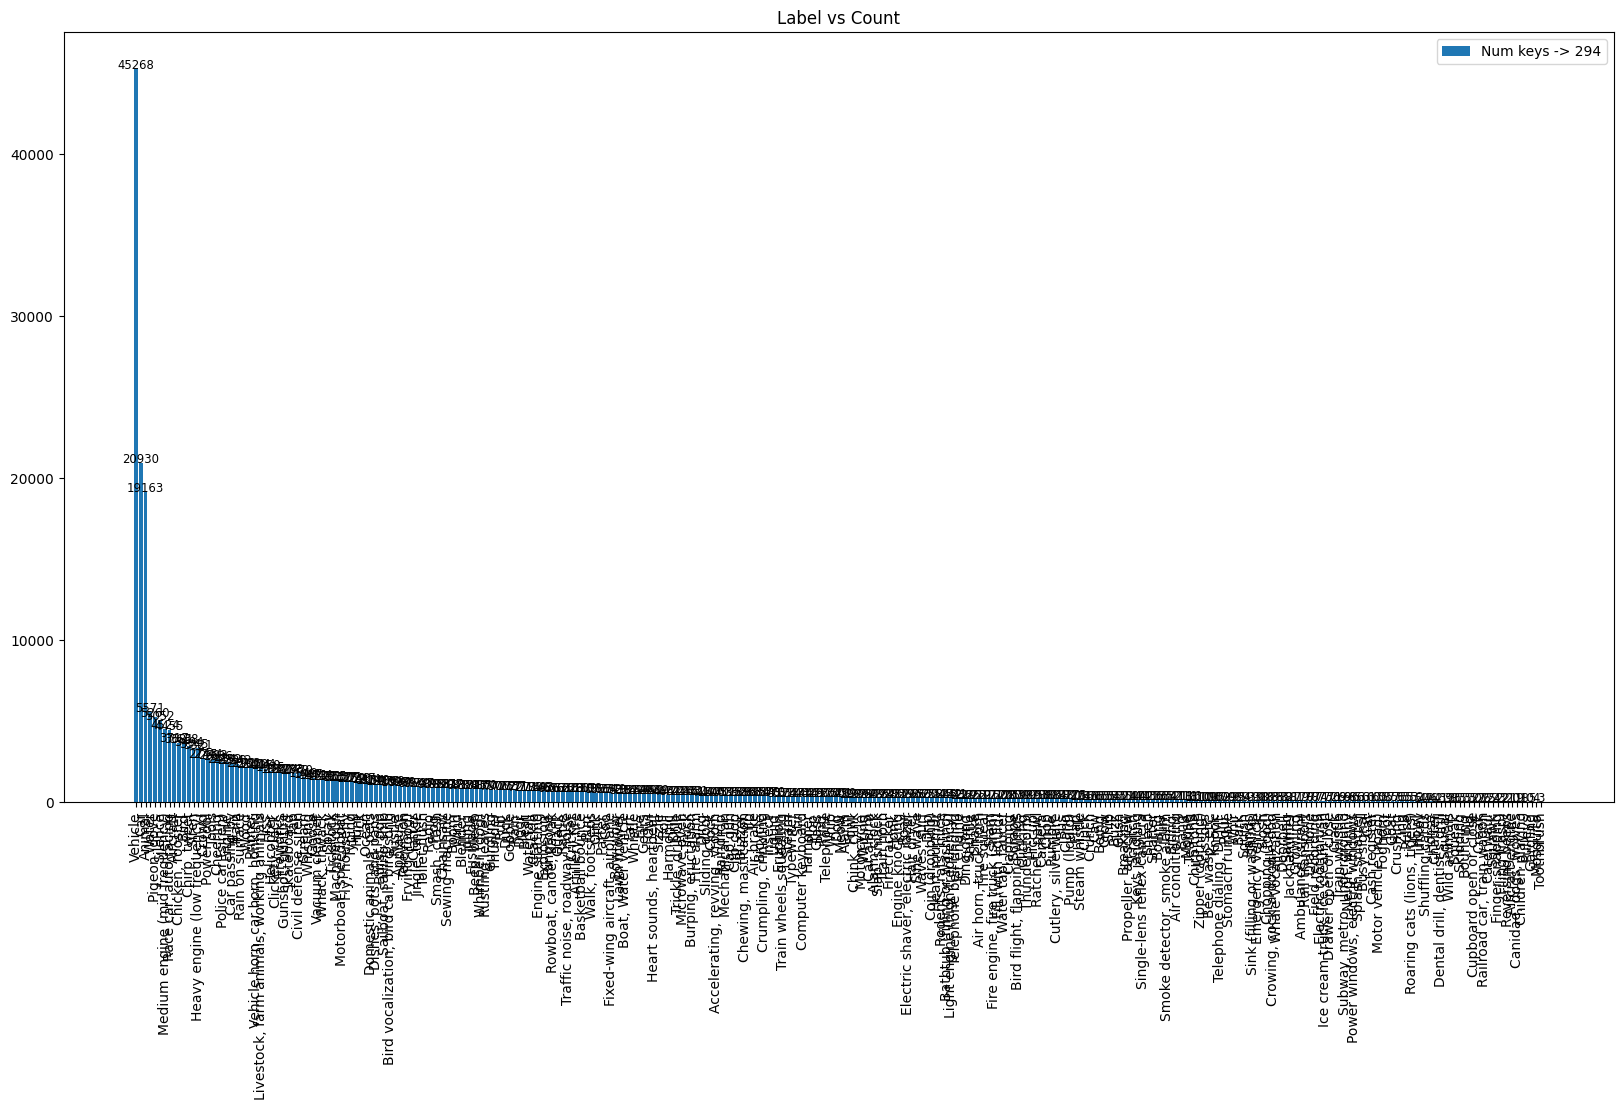

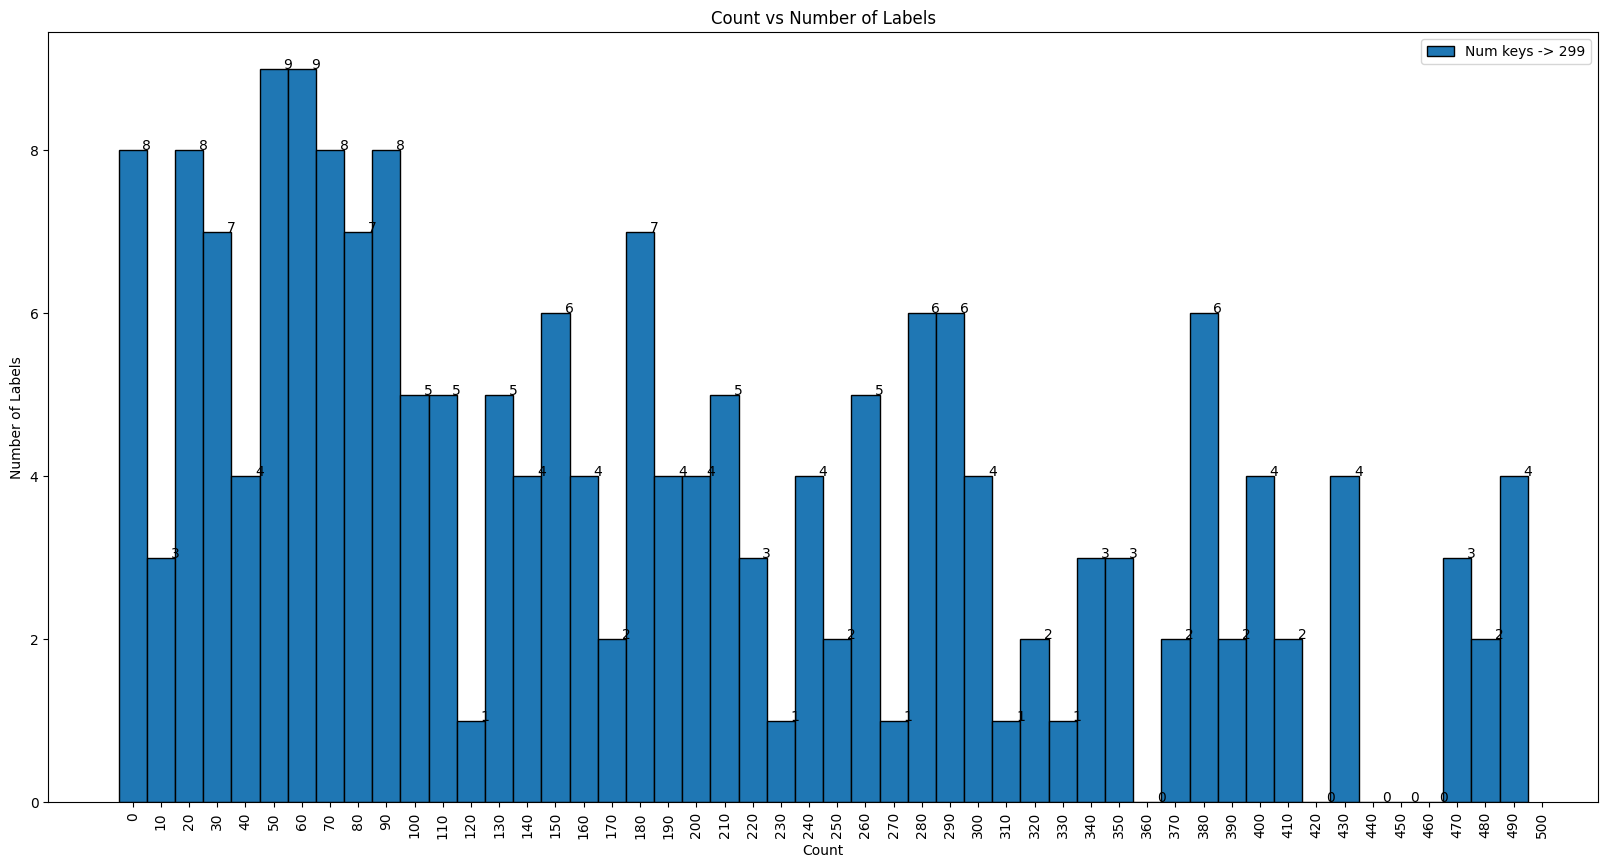

Sum of counts with label to count greater than min_num_samples -> 276409


In [16]:

label_selection_config_train = {
"min_num_samples_per_class" : 1,
"min_num_samples_per_for_visual_stimuli":100,
# "target_num_samples" : 450
}
label_selection_config_eval = {
"min_num_samples_per_class" : 10,
"min_num_samples_per_for_visual_stimuli":10,
# "target_num_samples" : 30
}

if split_type == 'train':
    label_selection_config = label_selection_config_train
    eval = False
    labels_considered = []
    
elif split_type == 'eval':
    label_selection_config = label_selection_config_eval
    eval = True
    with open('/tmp/bld56_dataset_v1/v1/audioset/it1_audioset_labels.json', 'r') as f:
        labels_considered = json.load(f)
        print(f"Num labels considered -> {len(labels_considered)}")
    
else:
    raise NotImplementedError(f"Split type {split_type} not implemented")


if file_type == 'normal':   
    ytid_to_label_max_duration, label_to_count, ytid_to_label = process_youtube_data_filtered(df, with_music=True, eval = eval)
elif file_type == 'strong':
    ytid_to_label_max_duration, label_to_count, ytid_to_label = process_youtube_data_with_max(df, with_music=True, eval = eval)

plot_label_vs_count(label_to_count, mid_to_label, label_selection_config["min_num_samples_per_class"] )

plot_percentile_label_vs_count(label_to_count, mid_to_label)

# print sum of counts with label to count greater than min_num_samples
print(f"Sum of counts with label to count greater than min_num_samples -> {sum([v for k, v in label_to_count.items() if v > label_selection_config['min_num_samples_per_class']])}")

In [17]:
sum = 0
for k, v in label_to_count.items():
    if v > label_selection_config['min_num_samples_per_class']:
        sum += v

print(f"Sum of counts -> {sum}")

Sum of counts -> 276409


In [18]:
# In ytid_to_label keep only keys that have label with count greater than min_num_samples
ytid_to_label = {k: v for k, v in ytid_to_label.items() if label_to_count[v['label']] > label_selection_config["min_num_samples_per_class"]}
# convert ytid_to_label to DataFrame
ytid_to_label_df = pd.DataFrame.from_dict(ytid_to_label, orient='index')
ytid_to_label_df = ytid_to_label_df.reset_index()
ytid_to_label_df.columns = ['YTID', 'label','duration', 'start_time', 'end_time']
ytid_to_label_df.head()

,YTID,label,duration,start_time,end_time
0,---1_cCGK4M,/m/07rwm0c,10.0,0.0,10.0
1,---fcVQUf3E,/m/07yv9,10.0,30.0,40.0
2,---lTs1dxhU,/t/dd00134,10.0,30.0,40.0
3,---yQzzLcFU,/t/dd00067,10.0,30.0,40.0
4,--0PQM4-hqg,/m/0j6m2,10.0,30.0,40.0


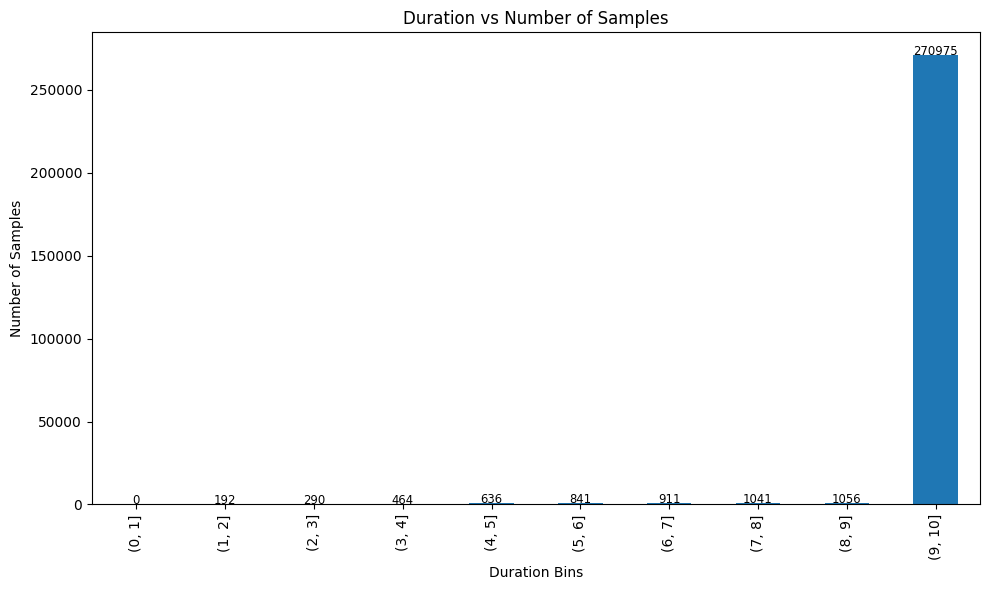

In [19]:
ytid_to_label_df = plot_binned_time_vs_num_samples(ytid_to_label_df,add_coloumn_of_probs=False, consider_num_samples_per_bin=False)

# Temporary (made for downloading the files from youtube.)

In [20]:
# save ytid_to_label_df to csv
file_path = f'/tmp/bld56_dataset_v1/audioset/v2/ytid_to_label_download_{split_type}_v2.csv'
# create till parent directory if not present
os.makedirs(os.path.dirname(file_path), exist_ok=True)
# edit start_time and end_time to start_seconds and end_seconds in main df
ytid_to_label_df.to_csv(file_path, index=False)

# For final audioset file making you can start from here.

### LOAD ABOVE FILE FOR FURTHER ANALYSIS

## Making final dataset and samples selected for dataset to mix with People's speech

### consider for more label skew handling without compramising on the number of unique samples by selecting some samples without repitition first and then selecting the rest with repitition

In [6]:
consider_labels = True
if file_type == 'strong':
    samples_per_class = label_selection_config["target_num_samples"]
    final_anns = pd.DataFrame()
    all_labels = ytid_to_label_df['label'].unique()

    for label in all_labels:
        df = ytid_to_label_df[ytid_to_label_df['label'] == label]
        if len(df) > samples_per_class:
            # Sample without replacement when enough samples are available
            df = df.sample(samples_per_class, weights=df['prbs_with_duration'], replace=False, random_state=42)
        else:
            # Ensure at least N unique samples
            unique_samples = df.sample(min(len(df), label_selection_config["min_num_samples_per_for_visual_stimuli"]), weights=df['prbs_with_duration'], replace=False, random_state=42)

            # Sample the remaining samples with replacement to reach the required number
            additional_samples_needed = samples_per_class - len(unique_samples)
            if additional_samples_needed > 0:
                additional_samples = df.sample(additional_samples_needed, weights=df['prbs_with_duration'], replace=True, random_state=42)
                df = pd.concat([unique_samples, additional_samples])
            else:
                df = unique_samples
        final_anns = pd.concat([final_anns, df])

    final_anns.reset_index(drop=True, inplace=True)
    print(len(final_anns))
    # save final_anns to json
    # final_anns.to_json(f'/tmp/bld56_dataset_v1/v1/audioset/audioset_anns_final_{split_type}.json', orient='records')
elif file_type == 'normal' and consider_labels:
   # Define the thresholds
    split_type = 'train'
    num_samples_to_keep_for_eval_per_class = 50
    num_samples_to_keep_for_test_per_class = 50
    label_selection_config = {}
    label_selection_config["min_num_samples_per_class"] = 550
    max_num_samples_per_class = 800

    # Load YTID to label mapping
    with open(f'/tmp/bld56_dataset_v1/audioset/v2/ytid_to_label_download_{split_type}.csv', 'r') as f:
        ytid_to_label_df = pd.read_csv(f)
    print(f"Number of samples before filtering: {len(ytid_to_label_df)}, unique labels: {len(ytid_to_label_df['label'].unique())}")

    # Load the info file to filter YTIDs
    with open(f'/tmp/bld56_dataset_v1/audioset/{split_type}/info_v2.json', 'r') as f:
        info = json.load(f)
    info = [i.split('/')[-1].split('.')[0] for i in info]

    # Filter YTIDs present in info
    ytid_to_label_df = ytid_to_label_df[ytid_to_label_df['YTID'].isin(info)]
    print(f"Filtered number of YTIDs in DataFrame: {len(ytid_to_label_df)}")

    # Get counts of each label
    label_counts = ytid_to_label_df['label'].value_counts()

    # Filter labels based on minimum sample count
    valid_labels = label_counts[label_counts > label_selection_config["min_num_samples_per_class"]].index
    if split_type == 'eval':
        with open(f'/tmp/bld56_dataset_v1/audioset/v2/it2_audioset_labels.json', 'r') as f:
            labels_considered = json.load(f)
        valid_labels = [label for label in valid_labels if label in labels_considered]
    ytid_to_label_df = ytid_to_label_df[ytid_to_label_df['label'].isin(valid_labels)]

    # To cap at max_num_samples_per_class
    def sample_labels(sub_df):
        return sub_df.sample(n=min(max_num_samples_per_class, len(sub_df)), random_state=1)

    ytid_to_label_df = ytid_to_label_df.groupby('label').apply(sample_labels).reset_index(drop=True)
    print(f"Number of samples after filtering: {len(ytid_to_label_df)}, unique labels: {len(ytid_to_label_df['label'].unique())}")

    def split_train_eval_test(sub_df, num_samples_for_eval, num_samples_for_test):
        """
        Splits a DataFrame into train, evaluation, and test subsets based on the given number of samples for eval and test.
        
        Args:
            sub_df (DataFrame): The DataFrame to split, representing a single class.
            num_samples_for_eval (int): The number of samples to allocate to the evaluation set.
            num_samples_for_test (int): The number of samples to allocate to the test set.

        Returns:
            train_samples (DataFrame): The remaining samples after eval and test samples are removed.
            eval_samples (DataFrame): The randomly sampled eval subset.
            test_samples (DataFrame): The randomly sampled test subset.
        """
        # Ensure that there are enough samples for splitting, otherwise adjust the numbers
        if len(sub_df) < (num_samples_for_eval + num_samples_for_test):
            num_samples_for_eval = int(len(sub_df) * 0.2)  # 20% for eval
            num_samples_for_test = int(len(sub_df) * 0.1)  # 10% for test
            if num_samples_for_eval + num_samples_for_test > len(sub_df):
                num_samples_for_test = len(sub_df) - num_samples_for_eval
        
        # Sample eval and test sets
        eval_samples = sub_df.sample(n=num_samples_for_eval, random_state=1)
        remaining_samples = sub_df.drop(eval_samples.index)
        test_samples = remaining_samples.sample(n=num_samples_for_test, random_state=1)
        train_samples = remaining_samples.drop(test_samples.index)
        
        return train_samples, eval_samples, test_samples

    # Example usage within a loop to split a large DataFrame by groups
    ytid_to_label_df_train = pd.DataFrame()
    ytid_to_label_df_eval = pd.DataFrame()
    ytid_to_label_df_test = pd.DataFrame()

    for label, sub_df in ytid_to_label_df.groupby('label'):
        train_samples, eval_samples, test_samples = split_train_eval_test(
            sub_df, 
            num_samples_to_keep_for_eval_per_class, 
            num_samples_to_keep_for_test_per_class
        )
        ytid_to_label_df_train = pd.concat([ytid_to_label_df_train, train_samples])
        ytid_to_label_df_eval = pd.concat([ytid_to_label_df_eval, eval_samples])
        ytid_to_label_df_test = pd.concat([ytid_to_label_df_test, test_samples])

    print(f"Number of samples after filtering (train): {len(ytid_to_label_df_train)}, unique labels: {len(ytid_to_label_df_train['label'].unique())}")
    print(f"Number of samples for eval: {len(ytid_to_label_df_eval)}, unique labels: {len(ytid_to_label_df_eval['label'].unique())}")
    print(f"Number of samples for test: {len(ytid_to_label_df_test)}, unique labels: {len(ytid_to_label_df_test['label'].unique())}")

    # Convert training DataFrame to JSON
    # repeat ytid_to_label_df_train like double the samples
    # ytid_to_label_df_train = pd.concat([ytid_to_label_df_train, ytid_to_label_df_train])
    # ytid_to_label_df_train.to_json(f'/tmp/bld56_dataset_v1/audioset/v2/audioset_anns_final_{split_type}_{file_type}_repeat.json', orient='records')

    ytid_to_label_df_train.to_json(f'/tmp/bld56_dataset_v1/audioset/v2/audioset_anns_final_{split_type}_{file_type}.json', orient='records')
    ytid_to_label_df_eval.to_json(f'/tmp/bld56_dataset_v1/audioset/v2/audioset_anns_final_eval_{file_type}.json', orient='records')
    ytid_to_label_df_test.to_json(f'/tmp/bld56_dataset_v1/audioset/v2/audioset_anns_final_test_{file_type}.json', orient='records')
    

    print("Completed filtering and saving the dataset.")

elif file_type == 'normal' and not consider_labels:
    eval_percent_to_seperate = 0.1
    # Load YTID to label mapping
    with open(f'/tmp/bld56_dataset_v1/audioset/v2/ytid_to_label_download_{split_type}.csv', 'r') as f:
        ytid_to_label_df = pd.read_csv(f)
    print(f"Number of samples before filtering: {len(ytid_to_label_df)}, unique labels: {len(ytid_to_label_df['label'].unique())}")

    # Load the info file to filter YTIDs
    with open(f'/tmp/bld56_dataset_v1/audioset/{split_type}/info_v2.json', 'r') as f:
        info = json.load(f)
    info = [i.split('/')[-1].split('.')[0] for i in info]

    # Filter YTIDs present in info
    ytid_to_label_df = ytid_to_label_df[ytid_to_label_df['YTID'].isin(info)]
    print(f"Filtered number of YTIDs in DataFrame: {len(ytid_to_label_df)}")
    label_counts = ytid_to_label_df['label'].value_counts()

    # Total number of samples in the evaluation set (10% of the original data)
    eval_size = int(len(ytid_to_label_df) * 0.1)

    # Create an empty DataFrame for the evaluation set
    ytid_to_label_df_eval = pd.DataFrame(columns=ytid_to_label_df.columns)

    # For each label, sample from the training set based on the proportion of that label
    for label, count in label_counts.items():
        # Determine the number of samples to include for this label in the evaluation set
        num_samples_eval = int(eval_size * (count / len(ytid_to_label_df)))

        # Sample the required number of rows for this label
        label_subset = ytid_to_label_df[ytid_to_label_df['label'] == label].sample(n=num_samples_eval, random_state=42)

        # Append to the evaluation set DataFrame
        ytid_to_label_df_eval = pd.concat([ytid_to_label_df_eval, label_subset], ignore_index=True)

    # Optionally, shuffle the evaluation set
    ytid_to_label_df_eval = ytid_to_label_df_eval.sample(frac=1, random_state=42).reset_index(drop=True)

    # The remaining data after removing the ytid_to_label_df_eval can be used as the new training set
    # Ensure all rows in ytid_to_label_df_eval are excluded from ytid_to_label_df_train
    ytid_to_label_df_train = ytid_to_label_df[~ytid_to_label_df['YTID'].isin(ytid_to_label_df_eval['YTID'])].reset_index(drop=True)

    # Print the size of the new sets
    print(f"Final size of eval set: {len(ytid_to_label_df_eval)}")
    print(f"Final size of training set: {len(ytid_to_label_df_train)}")
    
    os.makedirs(f'/tmp/bld56_dataset_v1/audioset/v2/', exist_ok=True)
    ytid_to_label_df_eval.to_csv(f'/tmp/bld56_dataset_v1/audioset/v2/audioset_anns_final_eval.json', index=False)
    ytid_to_label_df_train.to_csv(f'/tmp/bld56_dataset_v1/audioset/v2/audioset_anns_final_{split_type}.json', index=False)

# Check if any eval_set has any common samples with train_set
common_samples = ytid_to_label_df_eval[ytid_to_label_df_eval['YTID'].isin(ytid_to_label_df_train['YTID'])]
print(len(common_samples))

Number of samples before filtering: 92103, unique labels: 68
Filtered number of YTIDs in DataFrame: 67348
Number of samples after filtering: 31753, unique labels: 44
Number of samples after filtering (train): 27353, unique labels: 44
Number of samples for eval: 2200, unique labels: 44
Number of samples for test: 2200, unique labels: 44
Completed filtering and saving the dataset.
0


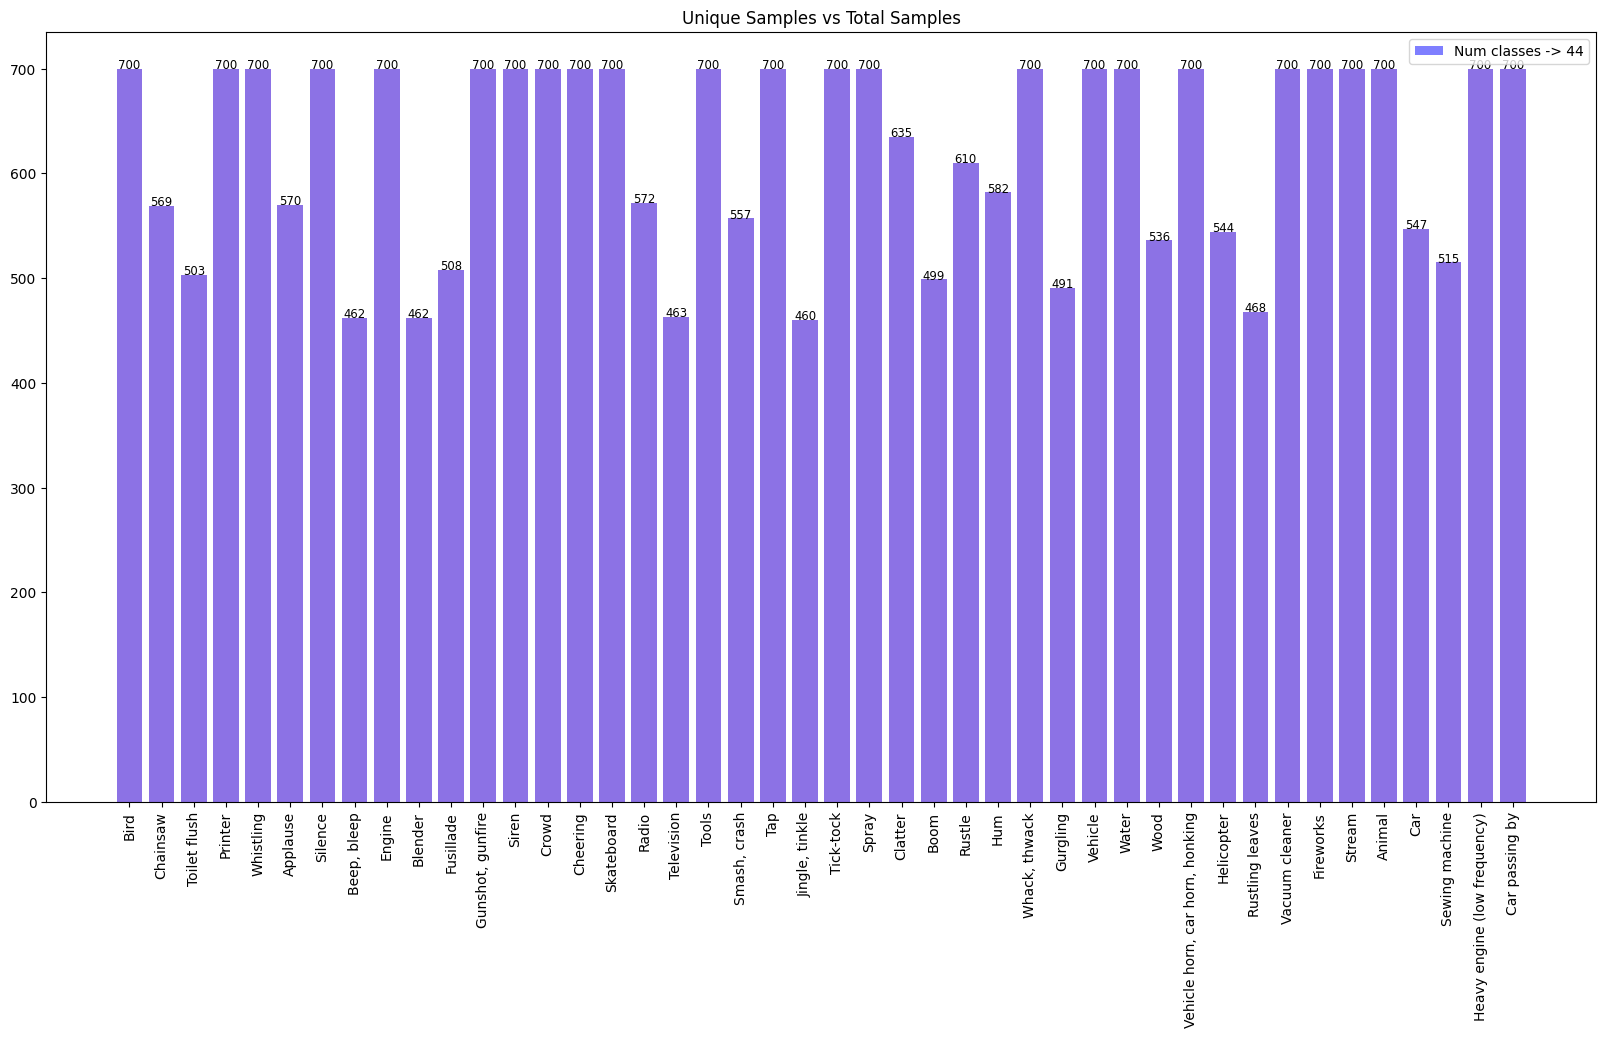

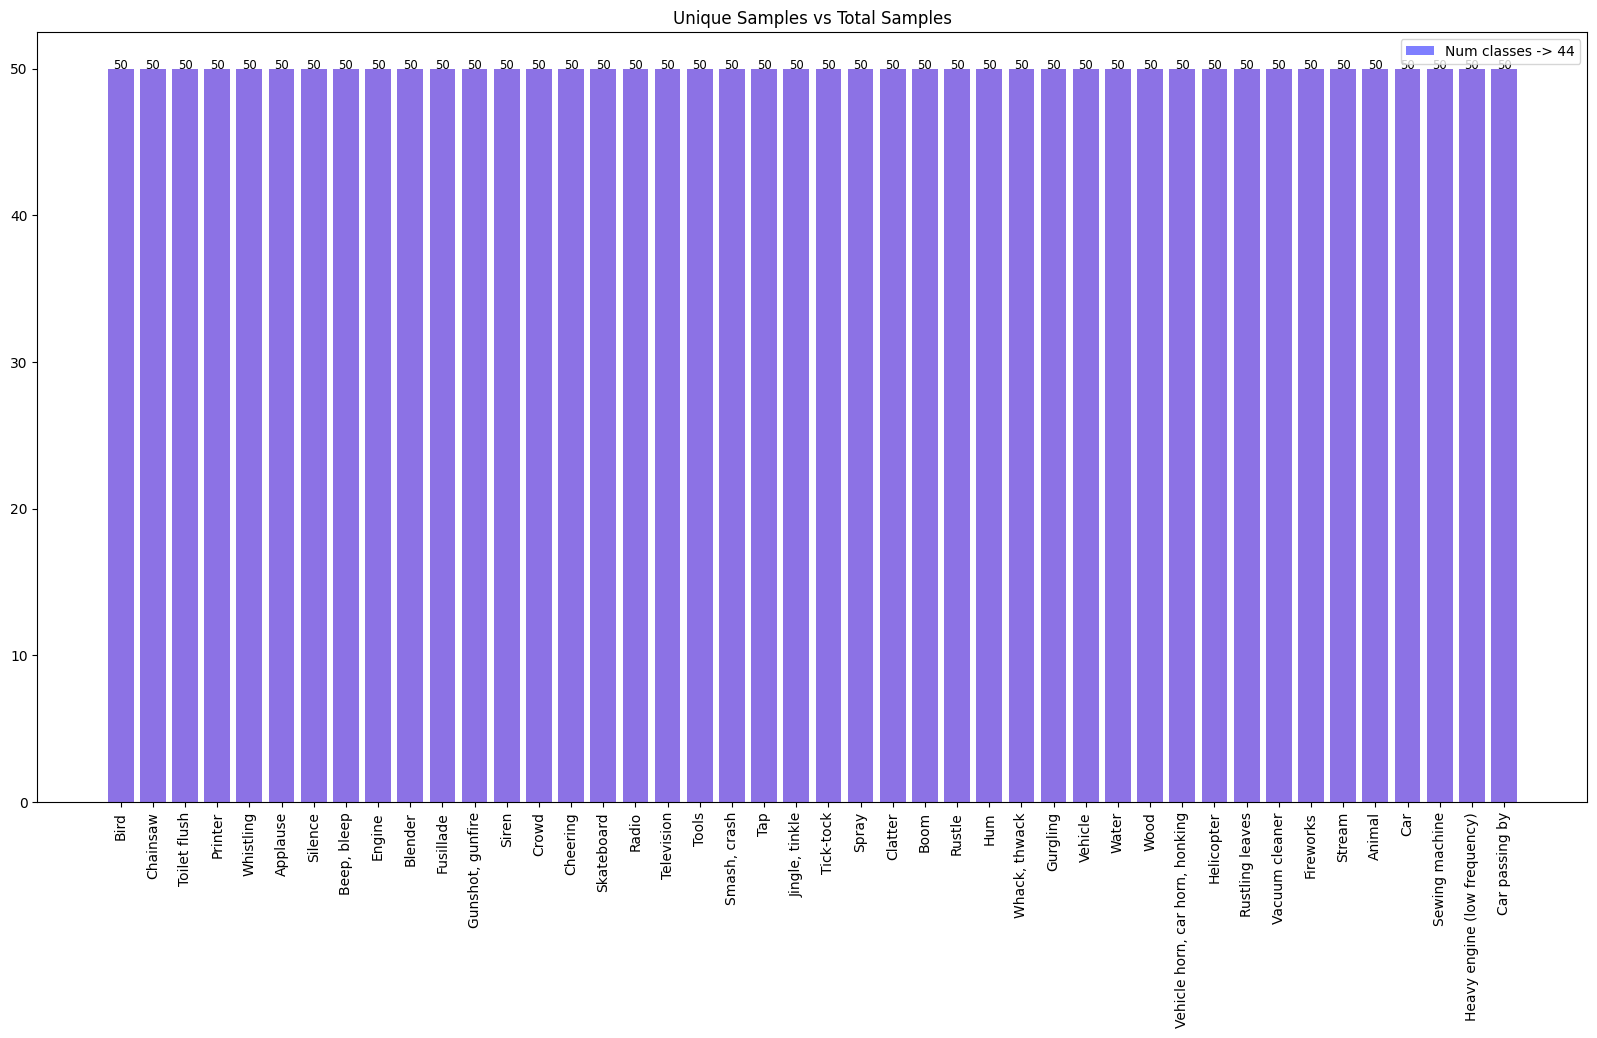

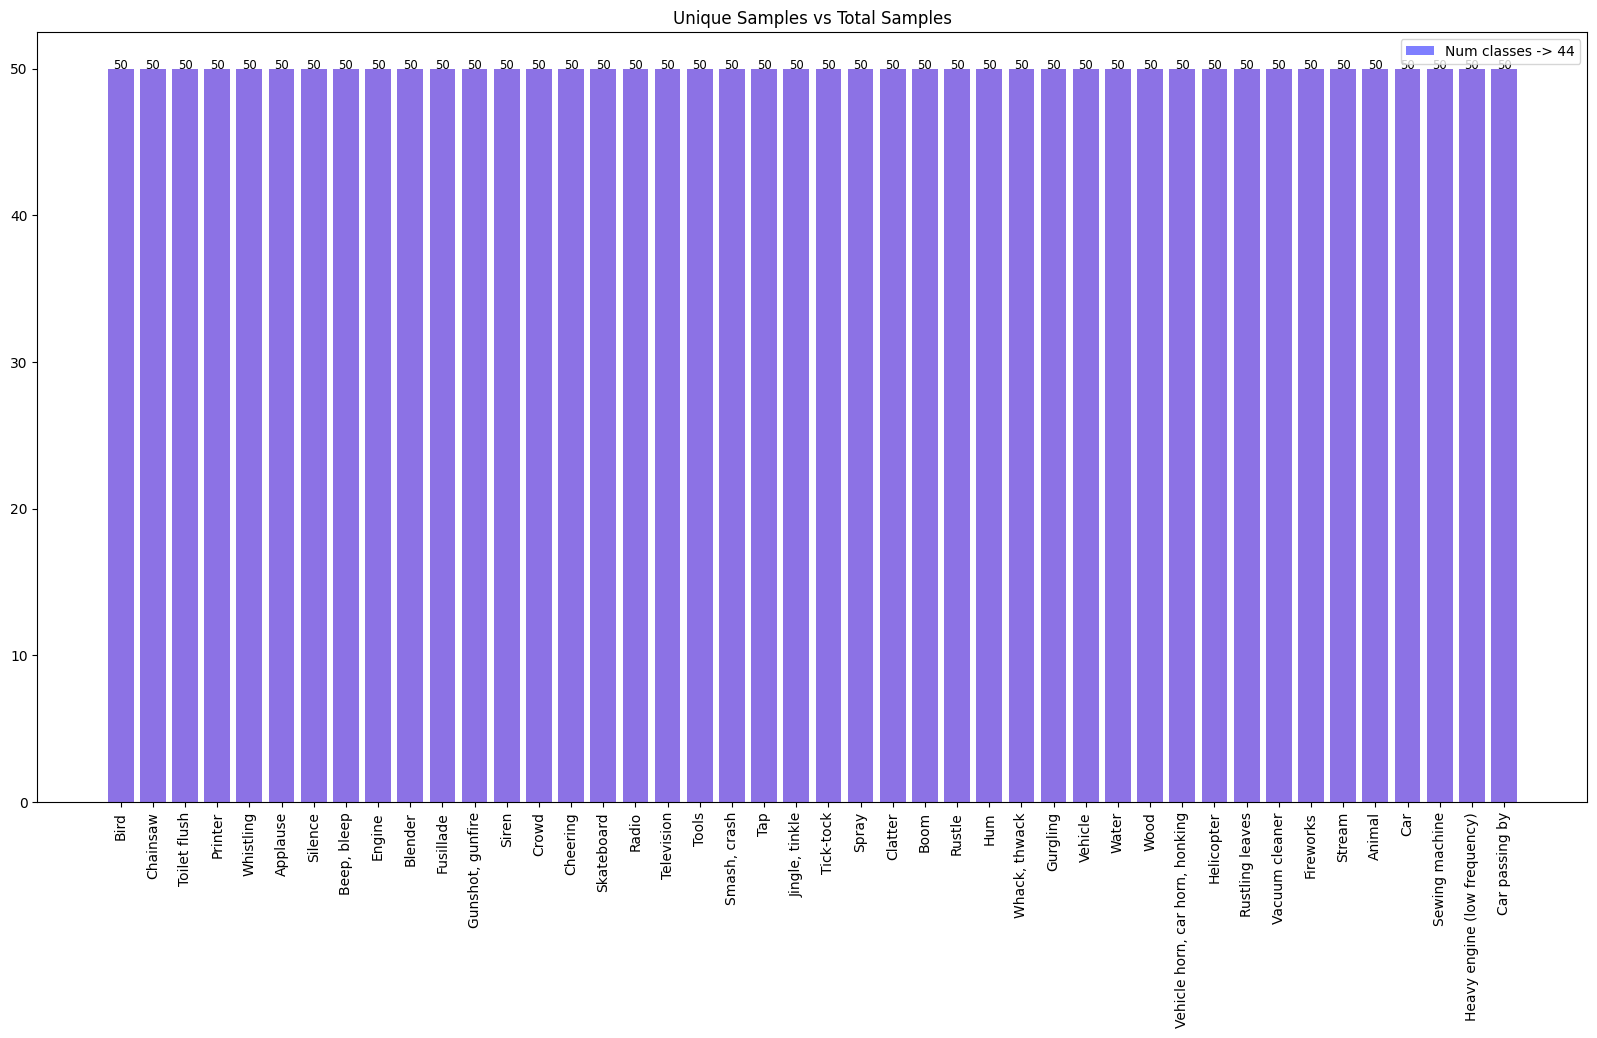

In [7]:
if file_type == 'strong':
    plot_binned_time_vs_num_samples(final_anns,add_coloumn_of_probs=False)

def plot_unique_samples_vs_total_samples(df):
    label_to_count = df['label'].value_counts()
    label_to_unique_count = df.groupby('label')['YTID'].nunique()
    plt.figure(figsize=(20, 10))
    # use mid_to_label to convert mid to label
    label_to_unique_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_unique_count.items()}
    label_to_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_count.items()}
    plt.bar(label_to_unique_count.keys(), label_to_unique_count.values(), color='b', alpha=0.5)
    # keep counts on top of bar
    for i, v in enumerate(label_to_unique_count.values()):
        plt.text(i, v, str(v), ha='center', fontsize='small')
    plt.bar(label_to_count.keys(), label_to_count.values(), color='r', alpha=0.1)
    plt.title('Unique Samples vs Total Samples')
    # wrtie num classes in legend
    plt.legend([f'Num classes -> {len(label_to_unique_count)}'])
    # x labels are rotated by 90 degrees for readability
    plt.xticks(rotation=90)
    plt.show()

mid_to_label = get_mid_to_label()
# V2
final_anns_train = pd.read_json(f'/tmp/bld56_dataset_v1/audioset/v2/audioset_anns_final_train_{file_type}.json')
final_anns_eval = pd.read_json(f'/tmp/bld56_dataset_v1/audioset/v2/audioset_anns_final_eval_{file_type}.json')
final_anns_test = pd.read_json(f'/tmp/bld56_dataset_v1/audioset/v2/audioset_anns_final_test_{file_type}.json')

# V3
# final_anns_train = pd.read_csv(f'/tmp/bld56_dataset_v1/audioset/v3/audioset_anns_final_train.json')
# final_anns_eval = pd.read_csv(f'/tmp/bld56_dataset_v1/audioset/v3/audioset_anns_final_eval.json')
plot_unique_samples_vs_total_samples(final_anns_train)
plot_unique_samples_vs_total_samples(final_anns_eval)
plot_unique_samples_vs_total_samples(final_anns_test)

In [8]:
labels_list = final_anns_eval['label'].unique()
print(f"Num labels -> {len(labels_list)}")
# save it as json
with open('/tmp/bld56_dataset_v1/audioset/v2/it2_audioset_labels.json', 'w') as f:
    json.dump(labels_list.tolist(), f)

Num labels -> 44


## LOADING ABOVE FINAL AUDIOSET ANNOTATION FOR DOWNLOADS ANALYSIS

In [63]:
config = {
    "file": f'/tmp/bld56_dataset_v1/v1/audioset/audioset_anns_final_{split_type}.json',
    "file_with_audioset_info": f'/tmp/bld56_dataset_v1/audioset/annotations/audioset_{split_type}_strong.csv',
    "videos_dir": f'/tmp/bld56_dataset_v1/audioset/{split_type}/videos',
    "feats_dir": f'/tmp/bld56_dataset_v1/audioset/{split_type}/feats_ViT-B-32_5fps',
    "as_info_file": f"/tmp/bld56_dataset_v1/audioset/{split_type}/info.json",
}
videos_list = os.listdir(config["videos_dir"])
feats_list = os.listdir(config["feats_dir"])
feats_list = [f.split('.')[0] for f in feats_list]
videos_list = [f.split('.')[0] for f in videos_list]
# get intersection of videos_list and feats_list
videos_list = set(videos_list).intersection(set(feats_list))
as_info = json.load(open(config["as_info_file"], 'r'))
no_issue_videos = []
for vid in as_info.keys():
    if as_info[vid]['has_video'] and as_info[vid]['has_audio']:
        no_issue_videos.append(vid.split('/')[-1].split('.')[0])
videos_list = set(videos_list).intersection(set(no_issue_videos))
data = {}
with open(config['file'], 'r') as f:
    data = json.load(f)

count = 0
missing_count = 0
# make unique set of ann['YTID'] and check if it is in videos_list
df_with_audioset_info = pd.read_csv(config['file_with_audioset_info'])
missing_df = pd.DataFrame()
all_ytids = set([ann['YTID'] for ann in data])
for vid in all_ytids:
    video_id_al_num = ''.join(e for e in vid if e.isalnum())
    if video_id_al_num in videos_list:
        count += 1
    else:
        missing_count += 1
        # find the row with YTID in df_with_audioset_info after doing df_with_audioset_info -> YTIDs with only alnum
        missing_df = pd.concat([missing_df, df_with_audioset_info[df_with_audioset_info['YTID'] == vid]])

print(count, missing_count)

# save missing_df to csv
# missing_df.to_csv('/tmp/bld56_dataset_v1/audioset/annotations/missing_files_{split_type}.csv', index=False)

6876 0


In [64]:
# give a plot based on final anns with only videos that are present (videos_list)
final_anns['parsed_YTID'] = final_anns['YTID'].apply(lambda vid: ''.join(e for e in vid if e.isalnum()))
final_anns_present = final_anns[final_anns['parsed_YTID'].isin(videos_list)]
final_anns_present.reset_index(drop=True, inplace=True)
final_anns_present.head()

,YTID,label,duration,start_time,end_time,binned_duration,prbs_with_duration,is_present,parsed_YTID
0,KGRESnKpsQc,/m/03m9d0z,9.517,0.000,9.517,"{'closed': 'right', 'closed_left': False, 'clo...",1,True,KGRESnKpsQc
1,wZMLc2eyvA0,/m/03m9d0z,10.000,0.000,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",1,True,wZMLc2eyvA0
2,hENOYy0oJgw,/m/03m9d0z,6.407,3.593,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",1,True,hENOYy0oJgw
3,XwGvi95LtSU,/m/03m9d0z,10.000,0.000,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",1,True,XwGvi95LtSU
4,7V7yhPBmpiI,/m/03m9d0z,6.886,0.000,6.886,"{'closed': 'right', 'closed_left': False, 'clo...",1,True,7V7yhPBmpiI


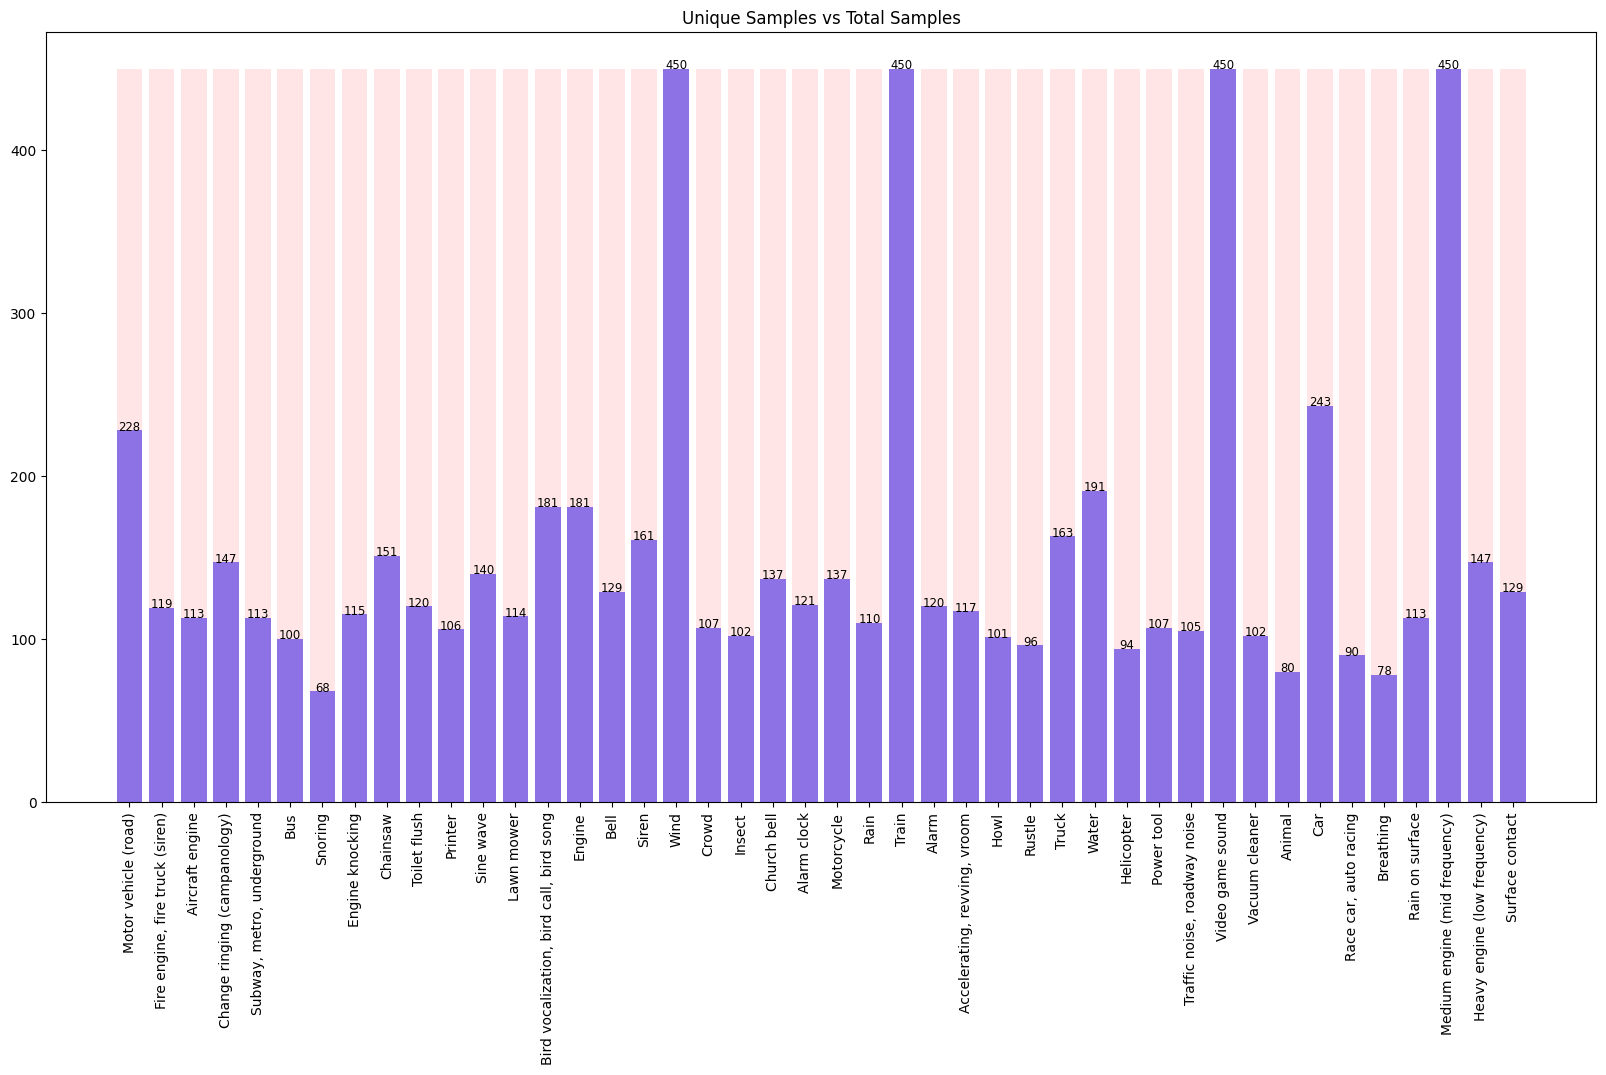

In [65]:
# plot_binned_time_vs_num_samples(final_anns_present,add_coloumn_of_probs=False)
plot_unique_samples_vs_total_samples(final_anns_present)
# final_anns_present.to_json(f'/tmp/bld56_dataset_v1/v1/audioset/audioset_anns_final_{split_type}_present.json', orient='records')

In [10]:
def extract_ytid_and_start(segment_id):
    ytid, startimems = segment_id.rsplit('_', 1)
    start_seconds = int(startimems) / 1000.0
    return ytid, start_seconds
split_type = 'train'
file = f'/tmp/bld56_dataset_v1/audioset/annotations/audioset_{split_type}_strong.tsv'
df = pd.read_csv(file, sep='\t')
# grp by YTID
# Apply the function to extract YTID and start_seconds
df['YTID'], df['start_seconds'] = zip(*df['segment_id'].map(extract_ytid_and_start))
df = df.groupby('YTID').agg({'label': lambda x: ','.join(x)}).reset_index()
base_dir = f"/tmp/bld56_dataset_v1/audioset/{split_type}/videos" # videos, feats_ViT-B-32_5fps
video_files = os.listdir(base_dir)
# remove extension from video_files
video_files = [f.split('.')[0] for f in video_files]

,YTID,label
0,--12UOziMF0,"/m/07r04,/t/dd00099,/t/dd00099,/t/dd00099,/t/d..."
1,--24LG2mr-Y,"/t/dd00004,/m/04rlf,/t/dd00004,/t/dd00004"
2,--330hg-Ocw,"/t/dd00066,/t/dd00099,/t/dd00099,/t/dd00099,/t..."
3,--5OkAjCI7g,"/m/01j3sz,/t/dd00077,/m/0dgw9r,/m/07s0dtb,/m/0..."
4,--7UmfOkRbM,"/m/05zppz,/t/dd00077,/m/09l8g,/m/05zppz,/m/09l..."


In [13]:

for ytid in tqdm(df['YTID'], total=len(df)):
    ytid_strip = ''.join(e for e in ytid if e.isalnum())
    if ytid_strip in video_files and ytid_strip != ytid:
        # rename the file to ytid.mp4
        if base_dir.endswith('fps'):
            os.rename(f"{base_dir}/{ytid_strip}.npy", f"{base_dir}/{ytid}.npy")
        else:
            os.rename(f"{base_dir}/{ytid_strip}.mp4", f"{base_dir}/{ytid}.mp4")
        print("what")
        break
    else:
        pass

100%|██████████| 103463/103463 [01:31<00:00, 1127.23it/s]


In [ ]:
split_type = 'train'
base_dir = f"/tmp/bld56_dataset_v1/audioset/{split_type}/videos"
video_files = os.listdir(base_dir)
# remove extension from video_files
video_files = [f.split('.')[0] for f in video_files]
# save this list as a json
# with open(f'/home/bld56/gsoc/general/{split_type}_videos_list_v1.json', 'w') as f:
#     json.dump(video_files, f)

### Temp to check if frames are loaded correctly in clip feat extract

In [ ]:

def frame_count(video_path, manual=False):
    def manual_count(handler):
        frames = 0
        while True:
            status, frame = handler.read()
            if not status:
                break
            frames += 1
        return frames

    cap = cv2.VideoCapture(video_path)
    # Slow, inefficient but 100% accurate method
    if manual:
        frames = manual_count(cap)
    # Fast, efficient but inaccurate method
    else:
        try:
            frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        except:
            frames = manual_count(cap)
    cap.release()
    return frames

def extract_frames(video_path, n, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    total_frames = frame_count(video_path)
    
    # Calculate evenly spaced frame indices
    frame_indices = np.linspace(0, total_frames - 1, n, dtype=int)

    frames = []
    for i, index in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        if ret:
            # Convert BGR frame to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Convert to PIL Image
            pil_image = Image.fromarray(frame_rgb)
            frames.append(pil_image)
            
            # Save the frame as an image file
            frame_filename = os.path.join(output_folder, f"frame_{i+1:04d}.png")
            pil_image.save(frame_filename)

    cap.release()
    return frames

video_path = '/tmp/bld56_dataset_v1/audioset/train/videos/000RBasAY7s.mp4'
n = 50
output_folder = '~/gsoc/general/test_frames/'

# extract_frames(video_path, n, output_folder)

### Temp to list all files with feats

In [5]:
file_json = '/home/bld56/gsoc/general/temps/gput_feats.json'
folder = '/tmp/bld56_dataset_v1/audioset/train/feats_ViT-L-14_5fps/'

files_extracted = os.listdir(folder)

with open(file_json, 'w') as f:
    json.dump(files_extracted, f)

print(f"Num files extracted -> {len(files_extracted)}")
print(files_extracted[:5])

Num files extracted -> 101486
['02klpDwy7YI.npy', 'ajK-gJ1IQJw.npy', '02xzX6J6Hj0.npy', '008W0O7ZT1E.npy', '02pl9PaQwmI.npy']


In [18]:
split = 'eval'
csv_path = f"/home/bld56/gsoc/general/download_logs/ytid_to_label_download_{split}.csv"
output_path = f"/tmp/bld56_dataset_v1/audioset/{split}/videos"
df = pd.read_csv(csv_path)
real_length = len(df)
print(f"Num YTIDs in csv -> {len(df)}")
videos_list = os.listdir(output_path)
videos_list = [f.split('.')[0] for f in videos_list]
# check num YTIDs not in videos_list
print(len(videos_list))
df = df[~df['YTID'].isin(videos_list)]
print(f"Num YTIDs not in videos_list -> {len(df)}")
print(f"Num downloaded {real_length - len(df)}")


Num YTIDs in csv -> 4067
10457
Num YTIDs not in videos_list -> 714
Num downloaded 3353


## Temp checking whether current manifests have any overlaps with in train, eval and test

In [12]:
paths={
    'train_labelled':"/tmp/bld56_dataset_v1/it2/annotations/manifest_train.json",
    'eval_labelled':"/tmp/bld56_dataset_v1/it2/annotations/manifest_eval.json",
    'test_labelled':"/tmp/bld56_dataset_v1/it2/annotations/manifest_test.json",
    'train_unlabelled':"/tmp/bld56_dataset_v1/it2/annotations/manifest_train_no_label.json",
    'eval_unlabelled':"/tmp/bld56_dataset_v1/it2/annotations/manifest_eval_no_label.json",
}
def load_json_lines(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data.append(json.loads(line.strip()))
            except:
                print(f"Error: {line}")
                # raise ValueError(f"Error in loading the file {file_path}")
    audio_file_paths = [d['audio_filepath'] for d in data]
    video_file_paths = [d['video_filepath'] for d in data]
    print(f"Loaded {len(data)} lines from {file_path} out of {len(data)}, len(set(audio_file_paths)) -> {len(set(audio_file_paths))}, len(set(video_file_paths)) -> {len(set(video_file_paths))}")
    return data, list(set(audio_file_paths)), list(set(video_file_paths))

In [14]:
# check if any of the train and eval files have intersection
train, train_audio, train_video = load_json_lines(paths['train_labelled'])
eval, eval_audio, eval_video = load_json_lines(paths['eval_labelled'])
test, test_audio, test_video = load_json_lines(paths['test_labelled'])
train_unlabelled, train_unlabelled_audio, train_unlabelled_video = load_json_lines(paths['train_unlabelled'])
eval_unlabelled, eval_unlabelled_audio, eval_unlabelled_video = load_json_lines(paths['eval_unlabelled'])
print(f"Intersection of train and eval -> {len(set(train_audio).intersection(set(eval_audio)))}")
print(f"Intersection of train and eval -> {len(set(train_video).intersection(set(eval_video)))}")
print(f"Intersection of train and test -> {len(set(train_audio).intersection(set(test_audio)))}")
print(f"Intersection of train and test -> {len(set(train_video).intersection(set(test_video)))}")
print(f"Intersection of eval and test -> {len(set(eval_audio).intersection(set(test_audio)))}")
print(f"Intersection of eval and test -> {len(set(eval_video).intersection(set(test_video)))}")
print(f"Intersection of train and train_unlabelled -> {len(set(train_audio).intersection(set(train_unlabelled_audio)))}")
print(f"Intersection of train and train_unlabelled -> {len(set(train_video).intersection(set(train_unlabelled_video)))}")
print(f"Intersection of eval and eval_unlabelled -> {len(set(eval_audio).intersection(set(eval_unlabelled_audio)))}")
print(f"Intersection of eval and eval_unlabelled -> {len(set(eval_video).intersection(set(eval_unlabelled_video)))}")
print(f"Intersection of test and eval_unlabelled -> {len(set(test_audio).intersection(set(eval_unlabelled_audio)))}")
print(f"Intersection of test and eval_unlabelled -> {len(set(test_video).intersection(set(eval_unlabelled_video)))}")

Loaded 27351 lines from /tmp/bld56_dataset_v1/it2/annotations/manifest_train.json out of 27351, len(set(audio_file_paths)) -> 27351, len(set(video_file_paths)) -> 27351
Loaded 2200 lines from /tmp/bld56_dataset_v1/it2/annotations/manifest_eval.json out of 2200, len(set(audio_file_paths)) -> 2200, len(set(video_file_paths)) -> 2200
Loaded 2200 lines from /tmp/bld56_dataset_v1/it2/annotations/manifest_test.json out of 2200, len(set(audio_file_paths)) -> 1245, len(set(video_file_paths)) -> 2200
Loaded 27351 lines from /tmp/bld56_dataset_v1/it2/annotations/manifest_train_no_label.json out of 27351, len(set(audio_file_paths)) -> 27351, len(set(video_file_paths)) -> 27351
Loaded 2200 lines from /tmp/bld56_dataset_v1/it2/annotations/manifest_eval_no_label.json out of 2200, len(set(audio_file_paths)) -> 2200, len(set(video_file_paths)) -> 2200
Intersection of train and eval -> 0
Intersection of train and eval -> 0
Intersection of train and test -> 0
Intersection of train and test -> 0
Intersec

## Temp for copying feats that are extracted to transfer to other nodes

In [4]:
already_present_files_path = "temps/gput_feats.json"
feats_base_path = "/tmp/bld56_dataset_v1/audioset/train/feats_ViT-L-14_5fps/"
copy_folder_path = "/tmp/bld56_dataset_v1/audioset/train/feats_1_ViT-L-14_5fps_from_gput065_v2"
os.makedirs(copy_folder_path, exist_ok=True)
already_present_files = []
with open(already_present_files_path, 'r') as f:
    already_present_files = json.load(f)
print(f"Num already present files -> {len(already_present_files)}")
print(already_present_files[:5])
current_files = os.listdir(feats_base_path)
# get current files - already_present_files
new_files = set(current_files).difference(set(already_present_files))
print(f"Num new files -> {len(new_files)}")

Num already present files -> 101486
['02klpDwy7YI.npy', 'ajK-gJ1IQJw.npy', '02xzX6J6Hj0.npy', '008W0O7ZT1E.npy', '02pl9PaQwmI.npy']
Num new files -> 8836


In [5]:
# copy new files to copy_folder_path
import shutil
for file in new_files:
    shutil.copy(f"{feats_base_path}/{file}", f"{copy_folder_path}/{file}")